In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [3]:
!pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers,models,optimizers,losses
import time

from IPython import display

In [5]:
(train_image,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

In [6]:
train_image = train_image[..., tf.newaxis].astype("float32")
train_images = (train_image - 127.5) / 127.5

In [7]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [8]:
train_ds=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-09-01 23:06:16.528092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-01 23:06:16.598475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-01 23:06:16.598865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-01 23:06:16.599679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [9]:
def createG():
    model = models.Sequential(
        [
            layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((7, 7, 256)),
            # shape=(7,7,256)
            # UpSampling
            layers.Conv2DTranspose(
                128, (5, 5), strides=(1, 1), padding="same", use_bias=False
            ),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            # shape = (7,7,128)
            layers.Conv2DTranspose(
                64, (5, 5), strides=(2, 2), padding="same", use_bias=False
            ),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            # shape = (14,14,64)
            layers.Conv2DTranspose(
                1,
                (5, 5),
                strides=(2, 2),
                padding="same",
                use_bias=False,
                activation="tanh",
            )
            # shape = (28,28,1)
        ]
    )
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

2022-09-01 23:06:19.687310: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-01 23:06:19.863021: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


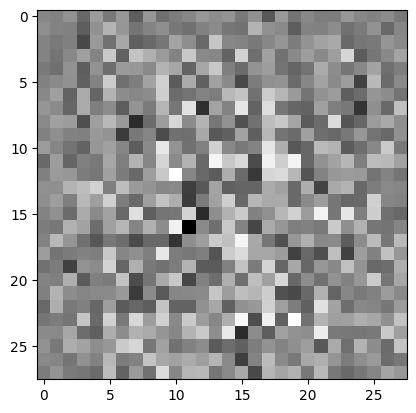

In [10]:
netG=createG()
print(netG.summary())

noise=tf.random.normal([1,100])
generated_image=netG(noise,training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [11]:
def createD():
    model = models.Sequential(
        [
            layers.Conv2D(
                64, (5, 5), strides=(2, 2), padding="same", input_shape=(28, 28, 1)
            ),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
            layers.LeakyReLU(),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(1),
        ]
    )
    return model

In [12]:
netD=createD()
print(netD.summary())

decision=netD(generated_image)
print(decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [13]:
cross_entropy=losses.BinaryCrossentropy(from_logits=True)

In [14]:
def netD_loss(real_out, fake_out):
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    total_loss= real_loss + fake_loss
    return total_loss

In [15]:
def netG_loss(fake_out):
    loss=cross_entropy(tf.ones_like(fake_out),fake_out)
    return loss

In [16]:
optimizer_netG=optimizers.Adam(1e-4)
optimizer_netD=optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = "./mnist_gan_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer_netG=optimizer_netD, optimizer_netD=optimizer_netD, netG=netG, netD=netD
)

In [18]:
EPOCHS=50
noise_dim=100
num_examples_to_generate=16

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as netG_tape, tf.GradientTape() as netD_tape:
        real_output = netD(images, training=True)

        fake_images = netG(noise,training=True)

        fake_output = netD(fake_images, training=True)

        errD_loss = netD_loss(real_output, fake_output)
        errG_loss = netG_loss(fake_output)

    gra_of_netD = netD_tape.gradient(errD_loss, netD.trainable_variables)
    gra_of_netG = netG_tape.gradient(errG_loss, netG.trainable_variables)
    
    optimizer_netD.apply_gradients(zip(gra_of_netD,netD.trainable_variables))
    optimizer_netG.apply_gradients(zip(gra_of_netG,netG.trainable_variables))

In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    # plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [23]:
def train(ds, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in ds:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(netG, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    display.clear_output(wait=True)
    generate_and_save_images(netG, epochs, seed)

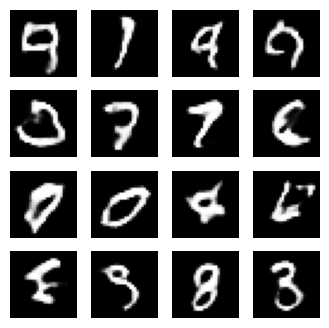

In [24]:
train(train_ds,EPOCHS)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
def display_image(epoch_no):
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_no))

In [27]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'